In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from utils.udp_util import extract_udp_prague_to_dataframe
from utils.plotter import  plot_siftr_graph

In [ ]:
# File paths

file_cubic = '../data/udp_net_2025-06-02-16-26-36/iperf3_client_cubic_iperf3_d120.json'
file_udp = '../data/udp_net_2025-06-02-16-26-36/udp_prague_receiver_iperf3_d120.json'


# file_udp = '../data/udp_net_2025-06-04-07-56-54/udp_prague_receiver_iperf3_d120.json'
# file_cubic = '../data/udp_net_2025-06-04-07-56-54/iperf3_client_cubic_iperf3_d120.json'

utf = extract_udp_prague_to_dataframe(file_udp)


In [3]:
utf

,Time,Rcvd_Mbps,Sent_Mbps,RTT_ms,Mark_pct,Mark_Marked,Mark_Total,Lost_pct,Lost_Lost,Lost_Total
0,0.00,0.001,0.000,0.000,0.00,0,1,0.0,0,1
1,1.00,3.340,0.053,8.107,26.67,80,300,0.0,0,300
2,2.01,3.476,0.055,8.199,28.94,90,311,0.0,0,311
3,3.01,3.502,0.055,8.182,24.28,76,313,0.0,0,313
4,4.01,3.152,0.050,8.314,25.89,73,282,0.0,0,282
...,...,...,...,...,...,...,...,...,...,...
112,112.21,3.796,0.060,8.561,20.65,70,339,0.0,0,339
113,113.21,4.617,0.073,8.353,23.73,98,413,0.0,0,413
114,114.22,4.168,0.066,8.758,22.79,85,373,0.0,0,373
115,115.22,3.478,0.055,8.478,23.40,73,312,0.0,0,312


In [4]:
import json
import numpy as np
import pandas as pd

def extract_data_df(filename):
    with open(filename) as f:
        data = json.load(f)

    records = []

    for interval in data['intervals']:
        record = {
            'time': interval['sum']['start'],
            'bitrate_mbps': interval['sum']['bits_per_second'] / 1_000_000
        }

        stream = interval['streams'][0]
        if 'rtt' in stream:
            record['rtt_time'] = stream['start']
            record['rtt_ms'] = stream['rtt'] / 1000.0  # µs to ms
        else:
            record['rtt_time'] = None
            record['rtt_ms'] = None

        records.append(record)

    df = pd.DataFrame(records)
    return df


In [5]:



# Function to extract data from iperf3 JSON
def extract_data(filename):
    with open(filename) as f:
        data = json.load(f)

    times = []
    bitrates = []
    rtt_times = []
    rtts = []

    for interval in data['intervals']:
        times.append(interval['sum']['start'])
        bitrates.append(interval['sum']['bits_per_second'] / 1_000_000)  # Convert to Mbit/s

        stream = interval['streams'][0]
        if 'rtt' in stream:
            rtt_times.append(stream['start'])
            rtts.append(stream['rtt'] / 1000.0)  # µs to ms

    return np.array(times), np.array(bitrates), np.array(rtt_times), np.array(rtts)





import os
os.path.exists(file_cubic)

# Extract data
t_cubic, b_cubic, rt_cubic, rtt_cubic = extract_data(file_cubic)

In [6]:
tfcubic = extract_data_df(file_cubic)

In [7]:
tfcubic.describe()

,time,bitrate_mbps,rtt_time,rtt_ms
count,118.000000,118.000000,118.000000,118.000000
mean,58.500273,3.803576,58.500273,26.501941
std,34.207709,0.802106,34.207709,6.521638
min,0.000000,2.084084,0.000000,11.729000
25%,29.250175,3.127618,29.250175,22.031750
50%,58.500231,4.169865,58.500231,26.353000
75%,87.750342,4.170631,87.750342,30.574750
max,117.000338,7.480698,117.000338,45.732000


In [8]:
utf.rename(columns={'RTT_ms': 'SmoothedRTT'}, inplace=True)
tfcubic.rename(columns={'rtt_ms': 'SmoothedRTT'}, inplace=True)


utf.rename(columns={'time': 'Time'}, inplace=True)
tfcubic.rename(columns={'time': 'Time'}, inplace=True)

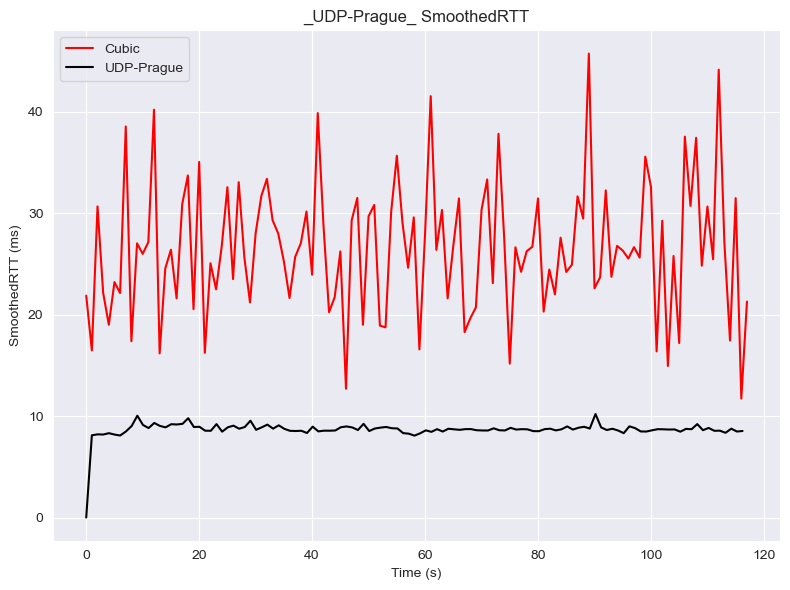

In [9]:
    # Define paths
paths = {
    "Cubic": tfcubic,
    "UDP-Prague": utf
}



scenario = str("_" + "UDP-Prague" + "_")

plot_siftr_graph(paths=paths,
                ycolumn="SmoothedRTT",
                title=f"{scenario} SmoothedRTT",
                xlabel="Time (s)",
                ylabel="SmoothedRTT (ms)",
                filename=f'{scenario}_SmoothedRTT',
                graph_directory="./",
)